# This notebook analyzes the Petrillo ML sample with the same LRG cuts from Petrillo and SDSS.
(i) The low-z (z < 0.4) LRG colour-magnitude selection of
Eisenstein et al. (2001), adapted to including more sources
(fainter and bluer):
r < 20
|c perp | < 0.2
r < 14 + c par /0.3
where
(1)
c par = 0.7(g − r) + 1.2[(r − i) − 0.18)]
c perp = (r − i) − (g − r)/4.0 − 0.18

(ii) A source size in the r -band larger than the average
FWHM of the PSF of the respective tiles, times a empir-
ical factor to maximize the separation between stars and galaxies.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.lines as lines
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from scipy import stats as sci

## g-band magnitude (AB)

In [2]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSg.fits')  # open a FITS file
hdul.verify('fix')
photo_g_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_g_id = photo_g_data.LAMID
# LAMID is GAMA ID where applicable.
photo_g_mag = photo_g_data.ABMagDFA

photo_g_list = list(zip(photo_g_id, photo_g_mag))

photo_g = pd.DataFrame(photo_g_list, columns = ['GAMA_ID', 'g'])
photo_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
GAMA_ID    220158 non-null object
g          220158 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [3]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_g['GAMA_ID'] = photo_g['GAMA_ID'].str.decode("utf-8")

In [4]:
# Remove IDs which have "New" in the name
photo_g = photo_g[~photo_g.GAMA_ID.str.contains('New')]
photo_g

,GAMA_ID,g
0,100000,20.594820
1,100001,20.743700
2,100002,18.867937
3,100003,20.013288
4,100004,19.506737
5,100005,17.884396
6,100006,18.100239
7,100007,20.343859
8,100008,18.569729
9,100009,19.702248


In [5]:
# Write IDs as integers
photo_g['GAMA_ID'] = photo_g.GAMA_ID.astype(int)

In [6]:
photo_g

,GAMA_ID,g
0,100000,20.594820
1,100001,20.743700
2,100002,18.867937
3,100003,20.013288
4,100004,19.506737
5,100005,17.884396
6,100006,18.100239
7,100007,20.343859
8,100008,18.569729
9,100009,19.702248


## r-band

In [7]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSr.fits')  # open a FITS file
hdul.verify('fix')
photo_r_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_r_id = photo_r_data.LAMID
# LAMID is GAMA ID where applicable.
photo_r_mag = photo_r_data.ABMagDFA

photo_r_list = list(zip(photo_r_id, photo_r_mag))

photo_r = pd.DataFrame(photo_r_list, columns = ['GAMA_ID', 'r'])
photo_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
GAMA_ID    220158 non-null object
r          220158 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [8]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_r['GAMA_ID'] = photo_r['GAMA_ID'].str.decode("utf-8")

In [9]:
# Remove IDs which have "New" in the name
photo_r = photo_r[~photo_r.GAMA_ID.str.contains('New')]
photo_r

,GAMA_ID,r
0,100000,19.811590
1,100001,19.662579
2,100002,17.846043
3,100003,19.200987
4,100004,19.207859
5,100005,17.286449
6,100006,17.592030
7,100007,19.783960
8,100008,17.508411
9,100009,19.131847


In [10]:
# Write IDs as integers
photo_r['GAMA_ID'] = photo_r.GAMA_ID.astype(int)

In [11]:
photo_r

,GAMA_ID,r
0,100000,19.811590
1,100001,19.662579
2,100002,17.846043
3,100003,19.200987
4,100004,19.207859
5,100005,17.286449
6,100006,17.592030
7,100007,19.783960
8,100008,17.508411
9,100009,19.131847


## i-band

In [12]:
# Opening GAMA LambdarCat data from G09, G12, and G15 (DR3)
hdul = fits.open('/home/shawn/Desktop/gravitational_lensing_research/FITS_Files/LambdarSDSSi.fits')  # open a FITS file
hdul.verify('fix')
photo_i_data = hdul[1].data  # assume the first extension is a table
#print(photo_g_data.columns)

# take ID and mag in g
photo_i_id = photo_i_data.LAMID
# LAMID is GAMA ID where applicable.
photo_i_mag = photo_i_data.ABMagDFA

photo_i_list = list(zip(photo_i_id, photo_i_mag))

photo_i = pd.DataFrame(photo_i_list, columns = ['GAMA_ID', 'i'])
photo_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220158 entries, 0 to 220157
Data columns (total 2 columns):
GAMA_ID    220158 non-null object
i          220158 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ MB


In [13]:
# GAMA_ID is given in bytes, need to decode. #b'8000'.decode("utf-8")
#photo_g_id.decode("utf-8")
photo_i['GAMA_ID'] = photo_i['GAMA_ID'].str.decode("utf-8")

In [14]:
# Remove IDs which have "New" in the name
photo_i = photo_i[~photo_i.GAMA_ID.str.contains('New')]
photo_i

,GAMA_ID,i
0,100000,19.469633
1,100001,19.226625
2,100002,17.358280
3,100003,18.706486
4,100004,18.875196
5,100005,16.981993
6,100006,17.225407
7,100007,19.467701
8,100008,17.013826
9,100009,18.811947


In [15]:
# Write IDs as integers
photo_i['GAMA_ID'] = photo_i.GAMA_ID.astype(int)
photo_i

,GAMA_ID,i
0,100000,19.469633
1,100001,19.226625
2,100002,17.358280
3,100003,18.706486
4,100004,18.875196
5,100005,16.981993
6,100006,17.225407
7,100007,19.467701
8,100008,17.013826
9,100009,18.811947


## Now I create variables to establish criteria for satisfying Petrillo's LRG classification.

## Now to see if Zoo passes the LRG cuts.

In [16]:
mac = pd.read_csv('/home/shawn/Desktop/gravitational_lensing_research/Lens_Project_Files/mac_candidates_021820.csv')
mac

,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e
0,0,3899011.0,2251.0,131.33397,-0.91563,64.0,3.294000e+11,0.4027,2.276871
1,1,376338.0,2660.0,132.98734,1.50468,30.0,3.034000e+11,0.3272,1.364552
2,2,323152.0,2967.0,130.54643,1.64325,30.0,8.277000e+11,0.7216,2.743990
3,3,663364.0,2669.0,140.35284,-0.97414,28.0,2.688000e+11,0.3221,2.321027
4,4,3629152.0,1933.0,135.88864,-0.97487,26.0,2.129000e+11,0.4059,1.320949
5,5,3575500.0,1906.0,129.23265,-1.57512,26.0,3.209000e+11,0.3652,1.185241
6,6,197972.0,2007.0,137.85838,-0.75280,24.0,3.551000e+11,0.3373,1.367670
7,7,3883690.0,2756.0,134.57492,-1.55142,22.0,1.362000e+11,0.2481,0.767594
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,2.407686
9,9,371400.0,2275.0,131.20438,1.00064,18.0,2.021000e+11,0.2948,1.751501


In [23]:
# create variables for the criteria
# convert to Johnson magnitude system (or # out addition for AB)
g = photo_g.g# + 0.013
r = photo_r.r# + 0.226
i = photo_i.i# + 0.296

c_par = 0.7*(g - r) + 1.2*((r - i) - 0.18)
c_perp = (r - i) - (g - r)/4.0 - 0.18

# add columns c_par and c_perp to zoo
mac['g'] = g
mac['r'] = r
mac['i'] = i
mac['c_par'] = c_par
mac['c_perp'] = c_perp
mac['g_r'] = g - r

mac

,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e,r,c_par,c_perp,g,i,g-r,g_r
0,0,3899011.0,2251.0,131.33397,-0.91563,64.0,3.294000e+11,0.4027,2.276871,19.811590,0.742609,-0.033850,20.594820,19.469633,0.783230,0.783230
1,1,376338.0,2660.0,132.98734,1.50468,30.0,3.034000e+11,0.3272,1.364552,19.662579,1.063929,-0.014327,20.743700,19.226625,1.081121,1.081121
2,2,323152.0,2967.0,130.54643,1.64325,30.0,8.277000e+11,0.7216,2.743990,17.846043,1.084641,0.052289,18.867937,17.358280,1.021894,1.021894
3,3,663364.0,2669.0,140.35284,-0.97414,28.0,2.688000e+11,0.3221,2.321027,19.200987,0.946012,0.111426,20.013288,18.706486,0.812302,0.812302
4,4,3629152.0,1933.0,135.88864,-0.97487,26.0,2.129000e+11,0.4059,1.320949,19.207859,0.392410,0.077943,19.506737,18.875196,0.298878,0.298878
5,5,3575500.0,1906.0,129.23265,-1.57512,26.0,3.209000e+11,0.3652,1.185241,17.286449,0.567910,-0.025030,17.884396,16.981993,0.597946,0.597946
6,6,197972.0,2007.0,137.85838,-0.75280,24.0,3.551000e+11,0.3373,1.367670,17.592030,0.579694,0.059571,18.100239,17.225407,0.508209,0.508209
7,7,3883690.0,2756.0,134.57492,-1.55142,22.0,1.362000e+11,0.2481,0.767594,19.783960,0.555440,-0.003715,20.343859,19.467701,0.559898,0.559898
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,2.407686,17.508411,1.120424,0.049256,18.569729,17.013826,1.061317,1.061317
9,9,371400.0,2275.0,131.20438,1.00064,18.0,2.021000e+11,0.2948,1.751501,19.131847,0.567161,-0.002700,19.702248,18.811947,0.570400,0.570400


In [24]:
# Take Petrillo's 1st set of criteria for LRG (z < 0.4)
mac_LRG = mac[(mac.r < 20) & (abs(mac.c_perp) < 0.2) & (mac.r < 14 + mac.c_par/0.3)]
#mac_LRG = zoo_LRG_1[abs(zoo_LRG_1.r) < 100]
mac_LRG

,Unnamed: 0,GAMA_ID,ID,RA,DEC,SCORE,STELLAR_MASS,Z,theta_e,r,c_par,c_perp,g,i,g-r,g_r
8,8,3911769.0,1704.0,138.66089,-1.11639,20.0,1.740000e+11,0.2794,2.407686,17.508411,1.120424,0.049256,18.569729,17.013826,1.061317,1.061317
18,18,165409.0,3098.0,181.19672,-2.72009,38.0,2.641000e+10,0.0196,0.463767,17.927132,1.226641,-0.015483,19.172352,17.451309,1.245220,1.245220
21,21,98583.0,2369.0,178.83655,0.88457,30.0,1.545000e+11,0.2828,2.053387,17.401047,1.293173,-0.004201,18.699261,16.900694,1.298214,1.298214
24,24,124486.0,2553.0,179.73003,-2.51895,28.0,8.541000e+10,0.1435,0.740108,19.387873,1.940855,0.083289,21.228781,18.664356,1.840908,1.840908
27,27,145278.0,1551.0,183.83234,-1.41031,24.0,2.159000e+11,0.1983,1.448421,17.451962,1.418676,-0.045077,18.924730,16.948847,1.472769,1.472769
35,35,568617.0,105.0,215.70692,-0.55323,36.0,3.163000e+11,0.4527,1.078956,18.607557,1.638089,-0.004892,20.251516,18.021460,1.643959,1.643959
36,36,619609.0,315.0,220.63545,0.29188,32.0,1.891000e+11,0.2075,1.333015,18.978403,1.583536,0.058239,20.492052,18.361752,1.513649,1.513649


## Only seven candidates pass the LRG cuts imposed by Petrillo.
This worries me.

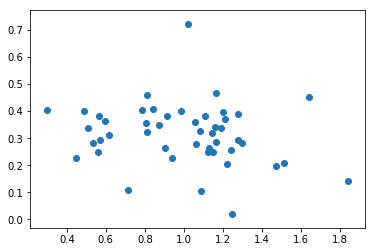

In [25]:
plt.scatter(mac.g_r, mac.Z)